In [0]:
# Traffic Sign Classification set
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip

--2020-04-26 18:32:29--  http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175675617 (168M) [application/zip]
Saving to: ‘trafficSignsHW.zip’

trafficSignsHW.zip  100%[===================>] 167.54M  10.9MB/s    in 14s     

2020-04-26 18:32:46 (11.9 MB/s) - ‘trafficSignsHW.zip’ saved [175675617/175675617]



In [0]:
!gdown https://drive.google.com/uc?id=16wLrX10hmc8C4yChAk25ajl66bAptDgI
import eplabtools as eplab

Downloading...
From: https://drive.google.com/uc?id=16wLrX10hmc8C4yChAk25ajl66bAptDgI
To: /content/eplabtools.py
100% 8.76k/8.76k [00:00<00:00, 19.0MB/s]


In [0]:
# Let us first import the necessary libraries
import numpy as np                                       # for linear algebra
import tensorflow as tf                                  # for neural models
import matplotlib.pyplot as plt                          # for plotting data
import time                                              # for measuring time
import zipfile                                           # for handling zip archives
import PIL                                               # for image handling
from keras import backend as K

In [0]:
# Let's introduce some definitions
IMG_SIZE = (32, 32)
IMG_SHAPE = (32, 32, 3)
NOF_CLASSES = 52

TRAIN_SET_PATH = '/content/trafficSignsHW/trainFULL'
TRAIN_SET_SIZE = 104027
TRAIN_BATCH_SIZE = 256

DEV_RATIO = 0.1             # 3920 dev images are enough
DEV_BATCH_SIZE = 256

TEST_SET_PATH = '/content/trafficSignsHW/testFULL'
TEST_SET_SIZE = 10418
TEST_BATCH_SIZE = 256

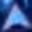

In [0]:
img_arr = np.array(PIL.Image.open('/content/trafficSignsHW/trainFULL/Bump/img(82000).jpg'))
eplab.showarray(img_arr)

In [0]:
# Flow training images in batches using train_datagen generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=DEV_RATIO)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='sparse',
    subset='training') # set as training data

dev_generator = train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=DEV_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # set as dev data

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 93627 images belonging to 52 classes.
Found 10400 images belonging to 52 classes.
Found 10418 images belonging to 52 classes.


In [0]:
augmented_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, validation_split=DEV_RATIO,
                                           rotation_range=15,
                                           width_shift_range=0.3,
                                           height_shift_range=0.3,
                                           shear_range=0.2,
                                           zoom_range=[0.8, 1.5],
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           fill_mode='nearest',
                                           data_format='channels_last',
                                           brightness_range=[0.5, 1.5])


augmented_train_generator = augmented_train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='sparse',
    subset='training') # set as training data

augmented_dev_generator = augmented_train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=DEV_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # set as dev data

augmented_test_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,
                                           rotation_range=15,
                                           width_shift_range=0.3,
                                           height_shift_range=0.3,
                                           shear_range=0.2,
                                           zoom_range=[0.8, 1.5],
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           fill_mode='nearest',
                                           data_format='channels_last',
                                           brightness_range=[0.5, 1.5]).flow_from_directory(
    TEST_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 93627 images belonging to 52 classes.
Found 10400 images belonging to 52 classes.
Found 10418 images belonging to 52 classes.


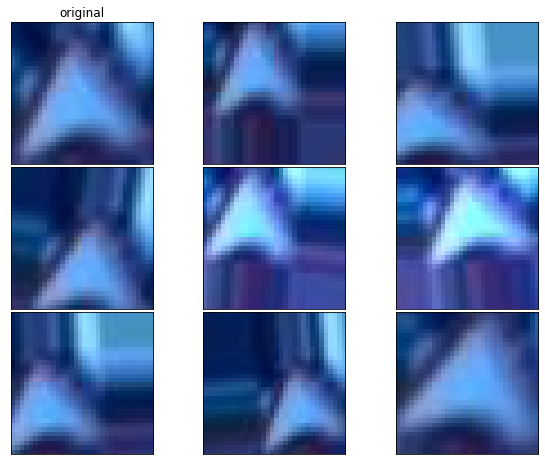

In [0]:
orig_img = np.array(PIL.Image.open('/content/trafficSignsHW/trainFULL/Bump/img(82001).jpg'))
eplab.augment_plot_pics(augmented_train_datagen, orig_img)

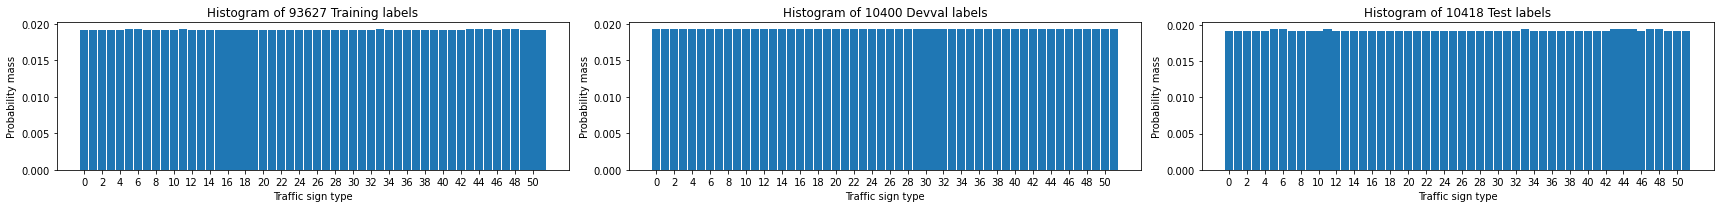

In [0]:
# Let's see a histogram of the categories
bins = np.arange(-0.5, 52, 1)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))

# the histogram of the data
for ax, setname, setlabels in zip(axs,
                                  ['Training', 'Devval', 'Test'],
                                  [train_generator.labels, dev_generator.labels, test_generator.labels]):
    ax.hist(setlabels, bins=bins, density=True, rwidth=0.9)
    ax.set_xlabel('Traffic sign type')
    ax.set_xticks(np.arange(0, 52, 2))
    ax.set_ylabel('Probability mass')
    ax.set_title(f'Histogram of {setlabels.size} {setname} labels')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

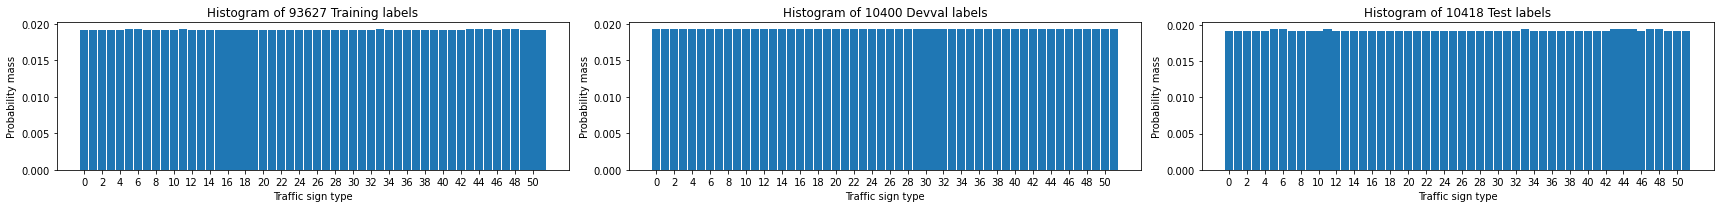

In [0]:
# Let's see a histogram of the AUGMENTED categories
bins = np.arange(-0.5, 52, 1)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))

# the histogram of the data
for ax, setname, setlabels in zip(axs,
                                  ['Training', 'Devval', 'Test'],
                                  [augmented_train_generator.labels, augmented_dev_generator.labels, augmented_test_generator.labels]):
    ax.hist(setlabels, bins=bins, density=True, rwidth=0.9)
    ax.set_xlabel('Traffic sign type')
    ax.set_xticks(np.arange(0, 52, 2))
    ax.set_ylabel('Probability mass')
    ax.set_title(f'Histogram of {setlabels.size} {setname} labels')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [0]:
# Define the model
def build_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMG_SHAPE, name='LAYER_01_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', name='LAYER_02_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='LAYER_03_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='LAYER_04_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(384, activation='relu', name='LAYER_05_fc'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.75),
        tf.keras.layers.Dense(NOF_CLASSES, activation='softmax', name='LAYER_06_fc')
    ])

    model.summary()

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.001),
                  metrics=['acc'])
    return model

In [0]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LAYER_01_cnv (Conv2D)        (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
LAYER_02_cnv (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
LAYER_03_cnv (Conv2D)        (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)       5

In [0]:
history = model.fit_generator(
    augmented_train_generator,
    steps_per_epoch = augmented_train_generator.samples // TRAIN_BATCH_SIZE,
    validation_data = augmented_dev_generator, 
    validation_steps = augmented_dev_generator.samples // DEV_BATCH_SIZE,
    epochs=10,
    verbose=1,
    shuffle=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
365/365 [==============================] - 89s 245ms/step - loss: 2.8141 - acc: 0.2857 - val_loss: 6.7591 - val_acc: 0.0571
Epoch 2/10
365/365 [==============================] - 88s 242ms/step - loss: 0.8467 - acc: 0.7303 - val_loss: 0.7576 - val_acc: 0.7766
Epoch 3/10
365/365 [==============================] - 89s 243ms/step - loss: 0.3334 - acc: 0.9031 - val_loss: 0.2750 - val_acc: 0.9234
Epoch 4/10
365/365 [==============================] - 88s 241ms/step - loss: 0.2075 - acc: 0.9423 - val_loss: 0.2076 - val_acc: 0.9386
Epoch 5/10
365/365 [==============================] - 88s 242ms/step - loss: 0.1529 - acc: 0.9571 - val_loss: 0.1615 - val_acc: 0.9493
Epoch 6/10
365/365 [==============================] - 89s 243ms/step - loss: 0.1238 - acc: 0.9646 - val_loss: 0.1328 - val_acc: 0.9618
Epoch 7/10
365/365 [==============================] - 89s 243ms/step - loss: 0.1046 - acc: 0.9704 - val_loss: 0.11

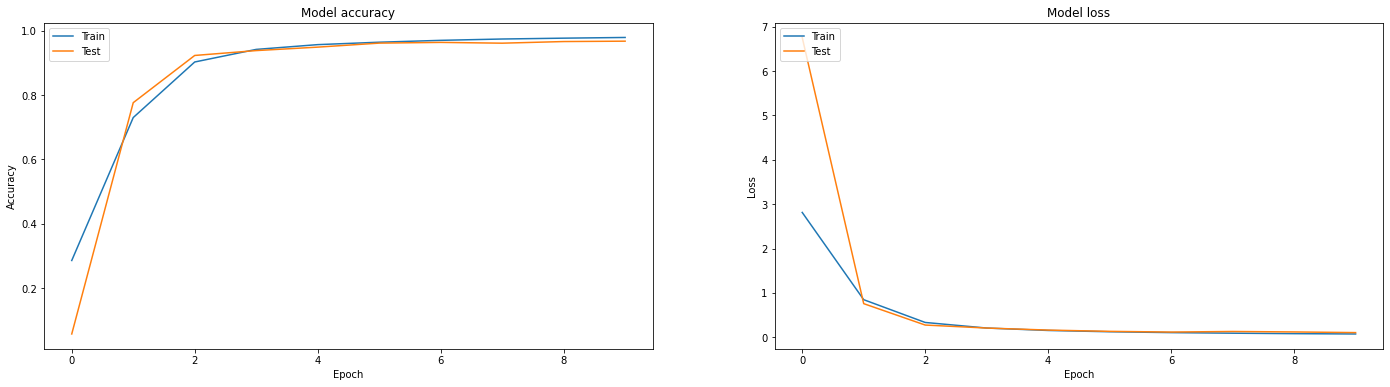

In [0]:
eplab.plot_history(history)

In [0]:
# devval performance
model.evaluate_generator(
    dev_generator,
    steps = dev_generator.samples // TEST_BATCH_SIZE
)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.057580672204494476, 0.982128918170929]

In [0]:
# FREEZING LAYERS for transfer learning (transfer from augmented to original distribution)
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-4:]:
        layer.trainable = True
        
    model.layers[-2].rate = 0.0  # lessened dropout rate

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.001),
                    metrics=['acc'])

In [0]:
# Freee model
freeze_model(model)

In [0]:
# transfer learn
historyTR = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // TRAIN_BATCH_SIZE,
    validation_data = dev_generator, 
    validation_steps = dev_generator.samples // DEV_BATCH_SIZE,
    epochs=10,
    verbose=1,
    shuffle=True)

Epoch 1/10
365/365 [==============================] - 22s 61ms/step - loss: 0.0132 - acc: 0.9966 - val_loss: 0.0502 - val_acc: 0.9833
Epoch 2/10
365/365 [==============================] - 22s 61ms/step - loss: 0.0068 - acc: 0.9983 - val_loss: 0.0564 - val_acc: 0.9816
Epoch 3/10
365/365 [==============================] - 22s 62ms/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.0528 - val_acc: 0.9826
Epoch 4/10
365/365 [==============================] - 22s 61ms/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.0561 - val_acc: 0.9827
Epoch 5/10
365/365 [==============================] - 22s 61ms/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 6/10
365/365 [==============================] - 22s 61ms/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0481 - val_acc: 0.9846
Epoch 7/10
365/365 [==============================] - 23s 62ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.0533 - val_acc: 0.9828
Epoch 8/10
365/365 [==============================] - 22s 61ms

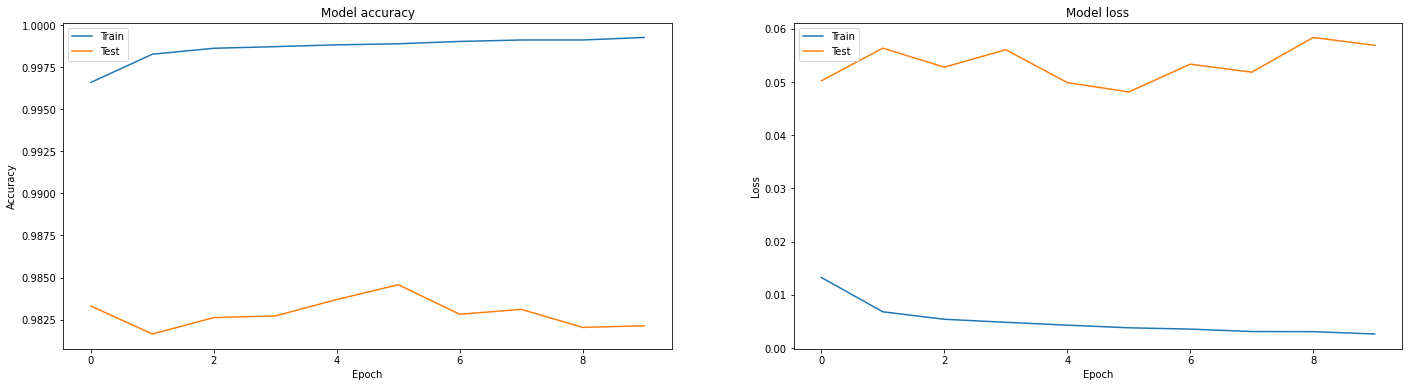

In [0]:
eplab.plot_history(historyTR)

In [0]:
# test performance
model.evaluate_generator(
    test_generator,
    steps = test_generator.samples // TEST_BATCH_SIZE
)

[0.026963036507368088, 0.9927734136581421]

[43. 50. 42. 22. 45.  2. 19.  9.  7. 43.]


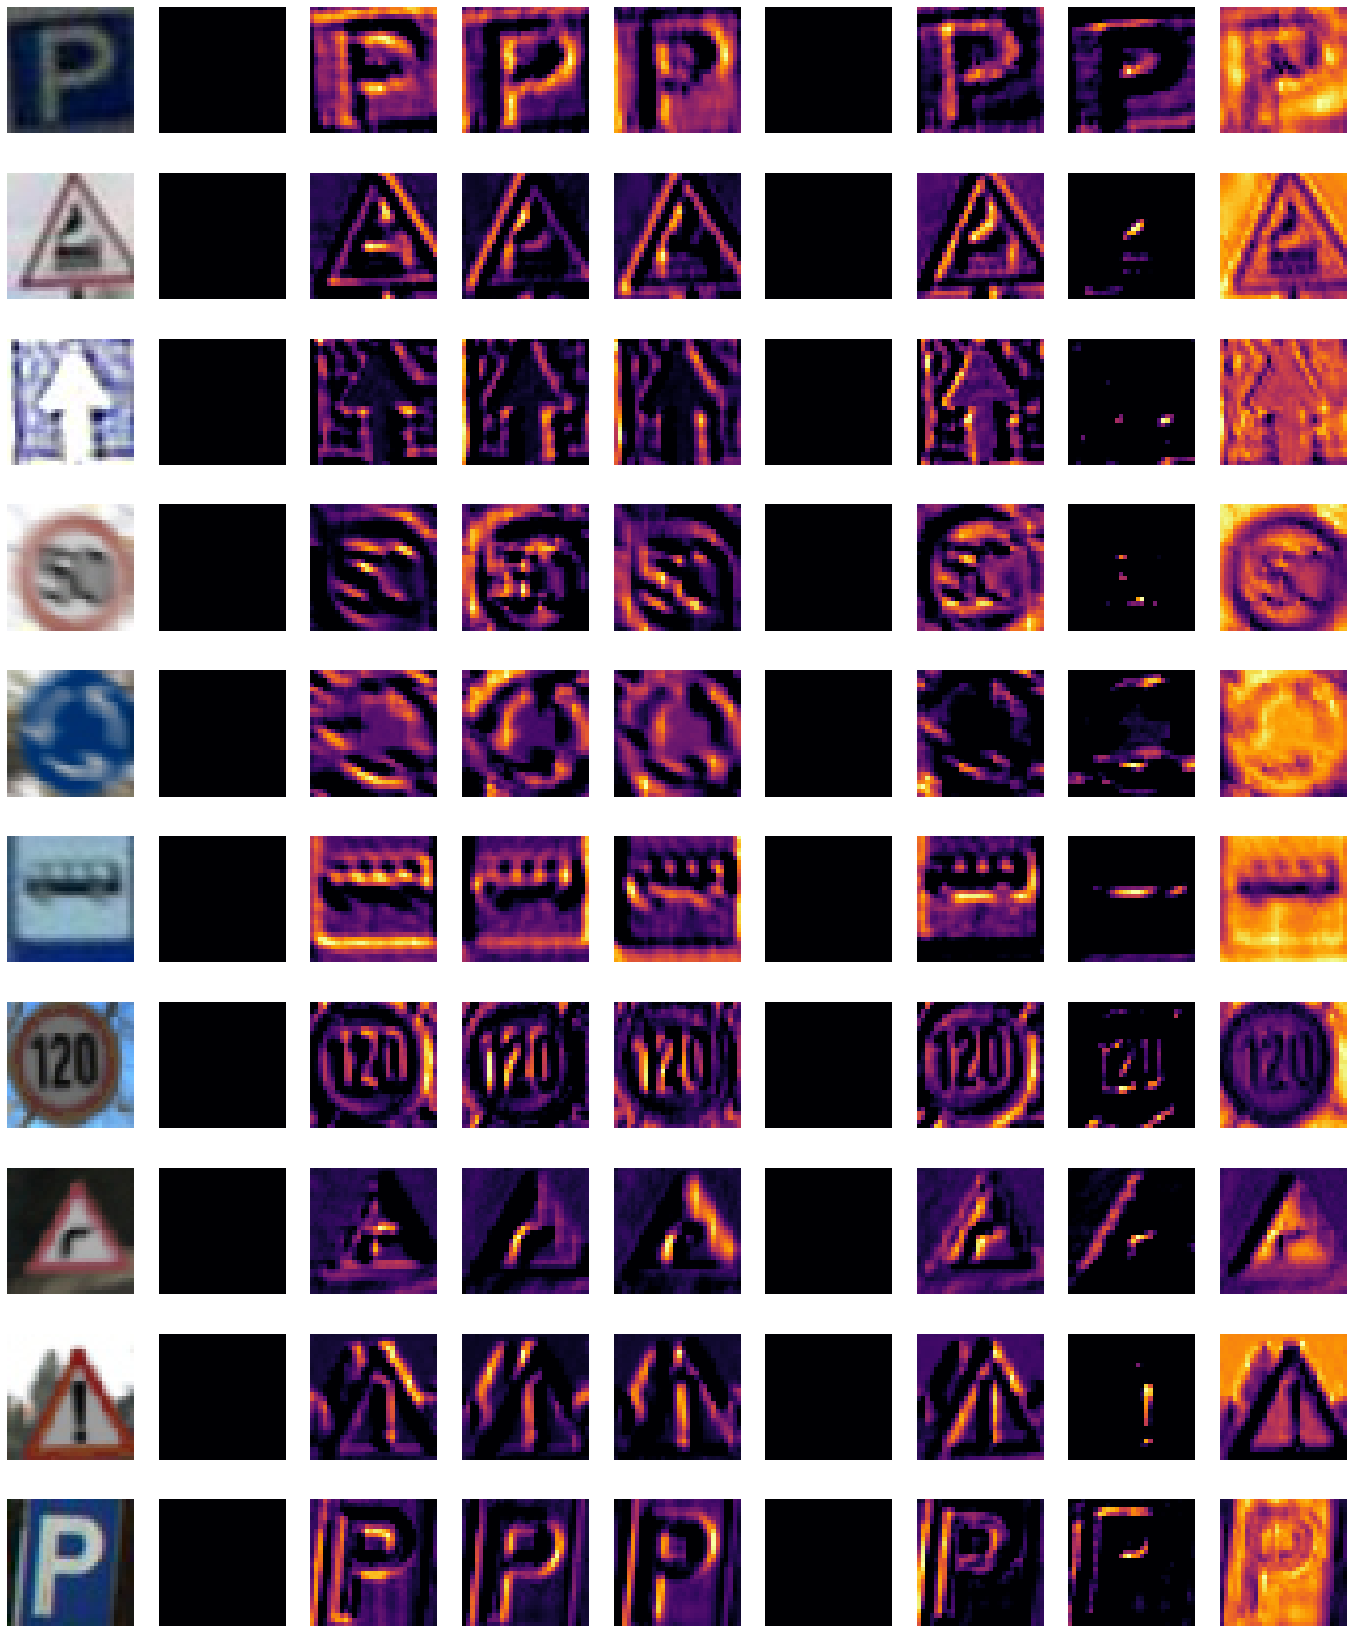

In [0]:
nof_try_images = 10
try_images = train_generator.__getitem__(0)[0][:nof_try_images]
try_labels = train_generator.__getitem__(0)[1][:nof_try_images]
print(try_labels)
eplab.plot_convs(model, try_images, layernum=0)